In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, LSTM, RepeatVector, TimeDistributed
from keras.models import Model
from keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [2]:
(x_train,_),(x_test,_)=mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
x_train=x_train.astype('float32') / 255
x_test=x_test.astype('float32')/255

In [4]:
x_train_fc = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_fc = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [5]:
input_shape = (28, 28, 1)

In [6]:
# Define the fully connected autoencoder
input_fc = Input(shape=(784,))
encoded_fc = Dense(32, activation='relu')(input_fc)
decoded_fc = Dense(784, activation='sigmoid')(encoded_fc)
autoencoder_fc = Model(input_fc, decoded_fc)

In [7]:
# Define the sparse autoencoder
input_sparse = Input(shape=(784,))
encoded_sparse = Dense(32, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_sparse)
decoded_sparse = Dense(784, activation='sigmoid')(encoded_sparse)
autoencoder_sparse = Model(input_sparse, decoded_sparse)

In [8]:
# Define the recurrent autoencoder
input_rnn = Input(shape=(28, 28))
encoded_rnn = LSTM(32)(input_rnn)
decoded_rnn = RepeatVector(28)(encoded_rnn)
decoded_rnn = LSTM(32, return_sequences=True)(decoded_rnn)
decoded_rnn = TimeDistributed(Dense(28, activation='sigmoid'))(decoded_rnn)
autoencoder_rnn = Model(input_rnn, decoded_rnn)

In [9]:
# Define the variational autoencoder
input_vae = Input(shape=(784,))
encoded_vae = Dense(256, activation='relu')(input_vae)
z_mean = Dense(2)(encoded_vae)
z_log_var = Dense(2)(encoded_vae)

In [10]:
# Define the convolutional autoencoder
input_cnn = Input(shape=input_shape)
x_cnn = Conv2D(16, (3, 3), activation='relu', padding='same')(input_cnn)
x_cnn = MaxPooling2D((2, 2), padding='same')(x_cnn)
x_cnn = Conv2D(8, (3, 3), activation='relu', padding='same')(x_cnn)
x_cnn = MaxPooling2D((2, 2), padding='same')(x_cnn)
x_cnn = Conv2D(8, (3, 3), activation='relu', padding='same')(x_cnn)
encoded_cnn = MaxPooling2D((2, 2), padding='same')(x_cnn)
x_cnn = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_cnn)
x_cnn = UpSampling2D((2, 2))(x_cnn)
x_cnn = Conv2D(8, (3, 3), activation='relu', padding='same')(x_cnn)
x_cnn = UpSampling2D((2, 2))(x_cnn)
x_cnn = Conv2D(16, (3, 3), activation='relu')(x_cnn)
x_cnn = UpSampling2D((2, 2))(x_cnn)
decoded_cnn = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x_cnn)
autoencoder_cnn = Model(input_cnn, decoded_cnn)

In [11]:
# Define a sampling function to sample from the learned distribution
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
z = layers.Lambda(sampling)([z_mean, z_log_var])
decoded_vae = Dense(784, activation='sigmoid')(z)
autoencoder_vae = Model(input_vae, decoded_vae)

In [13]:
# Compile all the autoencoders
autoencoder_fc.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_cnn.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_sparse.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_rnn.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_vae.compile(optimizer='adam', loss='binary_crossentropy')
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Load an example image
x = x_test[0]

In [15]:
# Predict the output using each autoencoder
x_fc_pred = autoencoder_fc.predict(np.expand_dims(x.flatten(), axis=0)).reshape(28, 28)
x_cnn_pred = autoencoder_cnn.predict(np.expand_dims(x, axis=0)).reshape(28, 28)
x_sparse_pred = autoencoder_sparse.predict(np.expand_dims(x.flatten(), axis=0)).reshape(28, 28)
x_rnn_pred = autoencoder_rnn.predict(np.expand_dims(x, axis=0)).reshape(28, 28)
x_vae_pred = autoencoder_vae.predict(np.expand_dims(x.flatten(), axis=0)).reshape(28, 28)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


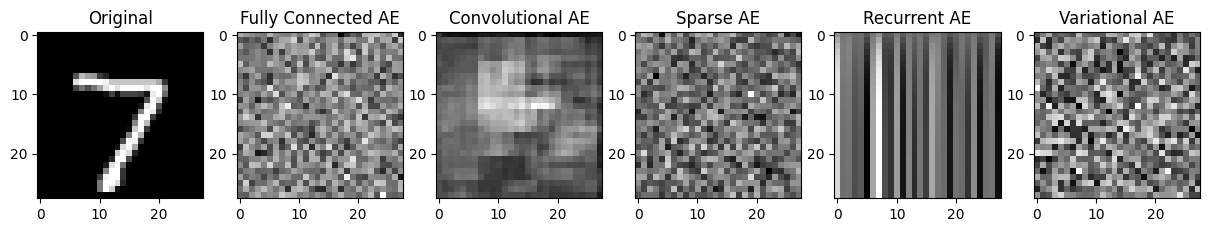

In [16]:
# Plot the original image and the predicted outputs
fig, axs = plt.subplots(1, 6, figsize=(15, 3))
axs[0].imshow(x, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(x_fc_pred, cmap='gray')
axs[1].set_title('Fully Connected AE')
axs[2].imshow(x_cnn_pred, cmap='gray')
axs[2].set_title('Convolutional AE')
axs[3].imshow(x_sparse_pred, cmap='gray')
axs[3].set_title('Sparse AE')
axs[4].imshow(x_rnn_pred, cmap='gray')
axs[4].set_title('Recurrent AE')
axs[5].imshow(x_vae_pred, cmap='gray')
axs[5].set_title('Variational AE')
plt.show()

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout
from tensorflow.keras.layers import MultiHeadAttention, Flatten, Reshape
from tensorflow.keras.layers import Add
from tensorflow.keras.optimizers import Adam

# Vanilla Transformer Encoder Block
def transformer_encoder(inputs, num_heads=2, ff_dim=64, dropout=0.1):
    # Multi-head self-attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(Add()([inputs, attn_output]))  # Residual connection

    # Feed-forward layer
    ff_output = Dense(ff_dim, activation="relu")(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    return LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))  # Residual connection

# Transformer Autoencoder for MNIST
input_trans = Input(shape=(28, 28))  # 28 time steps, 28 features
x_trans = transformer_encoder(input_trans, num_heads=2, ff_dim=128)
x_trans = transformer_encoder(x_trans, num_heads=2, ff_dim=128)

decoded_trans = TimeDistributed(Dense(28, activation='sigmoid'))(x_trans)

autoencoder_trans = Model(input_trans, decoded_trans)
autoencoder_trans.compile(optimizer=Adam(), loss='binary_crossentropy')

# Train (optional: use epochs=1 or few just to test)
# autoencoder_trans.fit(x_train, x_train, epochs=10, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# Prediction
x_vanilla_enc_pred = autoencoder_trans.predict(np.expand_dims(x, axis=0)).reshape(28, 28)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


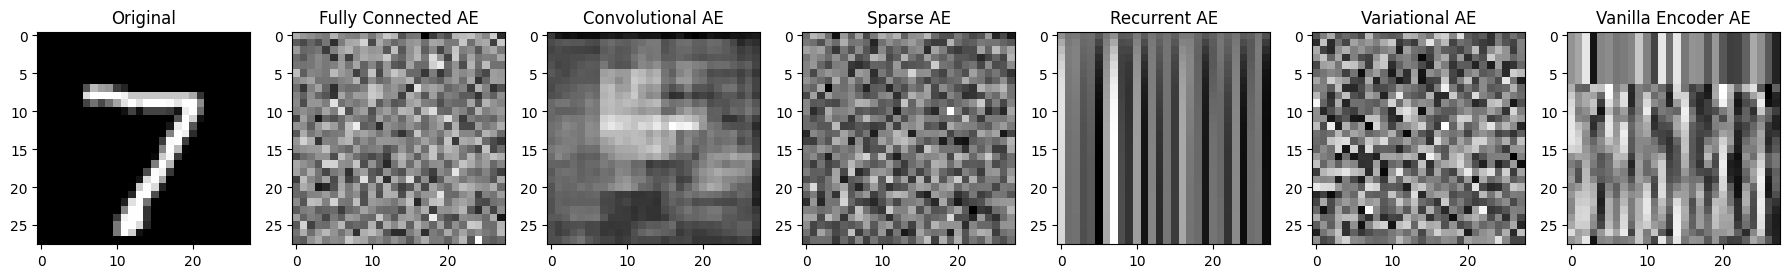

In [19]:
fig, axs = plt.subplots(1, 7, figsize=(18, 3))  # 7 plots now
axs[0].imshow(x, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(x_fc_pred, cmap='gray')
axs[1].set_title('Fully Connected AE')
axs[2].imshow(x_cnn_pred, cmap='gray')
axs[2].set_title('Convolutional AE')
axs[3].imshow(x_sparse_pred, cmap='gray')
axs[3].set_title('Sparse AE')
axs[4].imshow(x_rnn_pred, cmap='gray')
axs[4].set_title('Recurrent AE')
axs[5].imshow(x_vae_pred, cmap='gray')
axs[5].set_title('Variational AE')
axs[6].imshow(x_vanilla_enc_pred, cmap='gray')
axs[6].set_title('Vanilla Encoder AE')
plt.tight_layout()
plt.show()